# Library & Load Data

In [1]:
import gdown
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
file_id = "1VJ3UVjRBvfy_XzLmhLlYvhu0ICMbl9bX"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "data.zip", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1VJ3UVjRBvfy_XzLmhLlYvhu0ICMbl9bX
To: /content/data.zip
100%|██████████| 1.96M/1.96M [00:00<00:00, 47.8MB/s]


'data.zip'

In [3]:
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
data = pd.read_csv('Demo/train.csv')
df = pd.read_csv('Demo/test.csv')

# EDA

In [5]:
data.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [6]:
print(" 1: 'positive'    0: 'negative' ")

temp = data.groupby('label').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Blues_r')

 1: 'positive'    0: 'negative' 


,label,tweet
0,0,29720
1,1,2242


In [7]:
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [8]:
data = data.drop(columns=['id'])

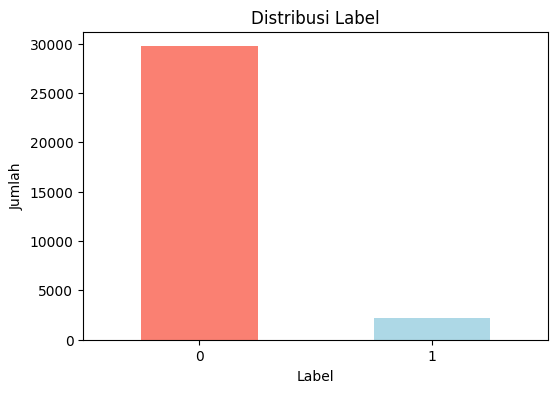

In [9]:
# Visualisasi distribusi label
plt.figure(figsize=(6,4))
data['label'].value_counts().plot(kind='bar', color=['salmon', 'lightblue'])
plt.title("Distribusi Label")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.xticks(rotation=0)
plt.show()

# PRE-PROCESSING

## Data Clean

In [10]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [11]:
!pip install emoji
import emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 7.1 MB/s eta 0:00:00


In [12]:
def remove_characters(text):
    text = re.sub(r'@\w+', '', text)                                # Username
    text = re.sub(r'https?:\/\/\S+', '', text)                      # Link
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower().strip())          # Lower Case
    text = re.sub(r'#', '', text)                                   # Hastag
    text = re.sub(r'\d+', '', text)                                 # Angka
    text = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+', '', text)  # Simbol-simbol
    text = re.sub(r'RT[\s]+', '', text)                             # Retweet / RT
    text = re.sub(r'\n', ' ', text)                                 # Newline
    text = emoji.replace_emoji(text, replace='')                    # Emoji atau emoticon
    text = re.sub(r'\s+', ' ', text)                                # Spasi ganda

    # Tokenisasi
    tokens = text.split()

    # Penghapusan stopwords dan lemmatization
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words]
    return " ".join(tokens)

In [13]:
data['cleaned_tweet'] = data['tweet'].apply(remove_characters)
data['cleaned_tweet'] = data['tweet'].apply(remove_characters)

In [14]:
data.head()

,label,tweet,cleaned_tweet
0,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...
1,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit use cause offer wheelchair ...
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in ...,model love u take u time ur
4,0,factsguide: society now #motivation,factsguide society motivation


# SPLITTING

In [15]:
X = data['cleaned_tweet']
y = data['label']

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

In [18]:
# Mengubah Teks Menjadi Sequences dan Melakukan Padding
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(data['cleaned_tweet']), maxlen=100)

# Model Lstm

In [19]:
# Bangun model LSTM
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [22]:
history = model.fit(X_train_seq, y_train, epochs=20, batch_size=32, validation_data=(X_val_seq, y_val))

Epoch 1/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 133s 161ms/step - accuracy: 0.9274 - loss: 0.2701 - val_accuracy: 0.9560 - val_loss: 0.1304
Epoch 2/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 124s 138ms/step - accuracy: 0.9706 - loss: 0.0902 - val_accuracy: 0.9612 - val_loss: 0.1183
Epoch 3/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 143s 139ms/step - accuracy: 0.9805 - loss: 0.0564 - val_accuracy: 0.9617 - val_loss: 0.1160
Epoch 4/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 144s 142ms/step - accuracy: 0.9901 - loss: 0.0321 - val_accuracy: 0.9607 - val_loss: 0.1535
Epoch 5/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 142s 142ms/step - accuracy: 0.9920 - loss: 0.0253 - val_accuracy: 0.9582 - val_loss: 0.1934
Epoch 6/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 111s 139ms/step - accuracy: 0.9948 - loss: 0.0162 - val_accuracy: 0.9578 - val_loss: 0.2291
Epoch 7/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 114s 142ms/step - accuracy: 0.9966 - loss: 0.0114 - val_accuracy: 0.9573 - val_loss: 0.2231
Epoch 8/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 140s 139ms/step - accuracy: 0.9967 -

KeyboardInterrupt: 

In [ ]:
loss, accuracy = model.evaluate(X_val_seq, y_val)
print(f'Test Accuracy: {accuracy}')
print(f'Test Loss: {loss}')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Akurasi Model')
    plt.ylabel('Akurasi')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Model')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

# Evaluasi Data Test

In [ ]:
df.head()

In [ ]:
df['cleaned_tweet'] = df['tweet'].apply(remove_characters)
X_test = df['cleaned_tweet']
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

In [ ]:
y_pred_test = (model.predict(X_test_seq) > 0.5).astype("int32")

In [ ]:
df['label'] = y_pred_test

In [ ]:
df.head()

In [ ]:
y_pred_val = (model.predict(X_val_seq) > 0.5).astype("int32")
print(classification_report(y_val, y_pred_val))

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Akurasi Model')
    plt.ylabel('Akurasi')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Model')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()